In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt_bpe'
MODELS_DIR = '/home/mlepekhin/models'
!ls {MODELS_DIR}
MODEL_ID = 'allennlp_rubert_lemma'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

allennlp_bert_base_cased		   allennlp_rubert_from_generated
allennlp_bert_base_cased_kek		   allennlp_rubert_lemma
allennlp_bert_base_uncased		   allennlp_simple_lstm
allennlp_bert_base_uncased_from_generated  big
allennlp_domain_lstm			   mini_gpt
allennlp_rubert				   mini_gpt_big_bpe
allennlp_rubert_base_cased_conversational  mini_gpt_bpe
allennlp_rubert_base_cased_kek		   mini_gpt_bpe_tuned


In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [11]:
!ls {pathjoin(MODELS_DIR, 'allennlp_rubert_lemma')}

checkpoints


In [6]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mlepekhin/models/allennlp_rubert_lemma/vocab/.lock'

In [ ]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

In [ ]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

### Data loading

In [5]:
ru_test_df = pd.read_csv(pathjoin(DATA_DIR, 'ru_lemma.csv'))
ru_test_df.head()

,Unnamed: 0,target,text
0,0,A4,острие свои товарищ и до конец . господин де т...
1,1,A4,"##зарядковатыи рисунок , и через весь время пр..."
2,2,A4,"картинныи , что выходка она скоро узнать она ч..."
3,3,A4,"иммунитет против компания не пощадить , потому..."
4,4,A4,"черта весь . - в декабрь , - - поправить эол ...."


In [8]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

10


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.425 precision 0.85 recall 0.2833333333333333
label (fictive) f1_score 0.888888888888889 precision 0.8 recall 1.0
label (instruct) f1_score 0.9230769230769231 precision 0.9 recall 0.9473684210526315
label (reporting) f1_score 0.888888888888889 precision 0.8 recall 1.0
label (legal) f1_score 0.7692307692307692 precision 0.75 recall 0.7894736842105263
label (personal) f1_score 0.24999999999999997 precision 0.15 recall 0.75
label (commercial) f1_score 0.9523809523809523 precision 1.0 recall 0.9090909090909091
label (research) f1_score 0.761904761904762 precision 0.8 recall 0.7272727272727273
label (info) f1_score 0.18181818181818182 precision 0.1 recall 1.0
label (eval) f1_score 0.9 precision 0.9 recall 0.9
accuracy 0.705


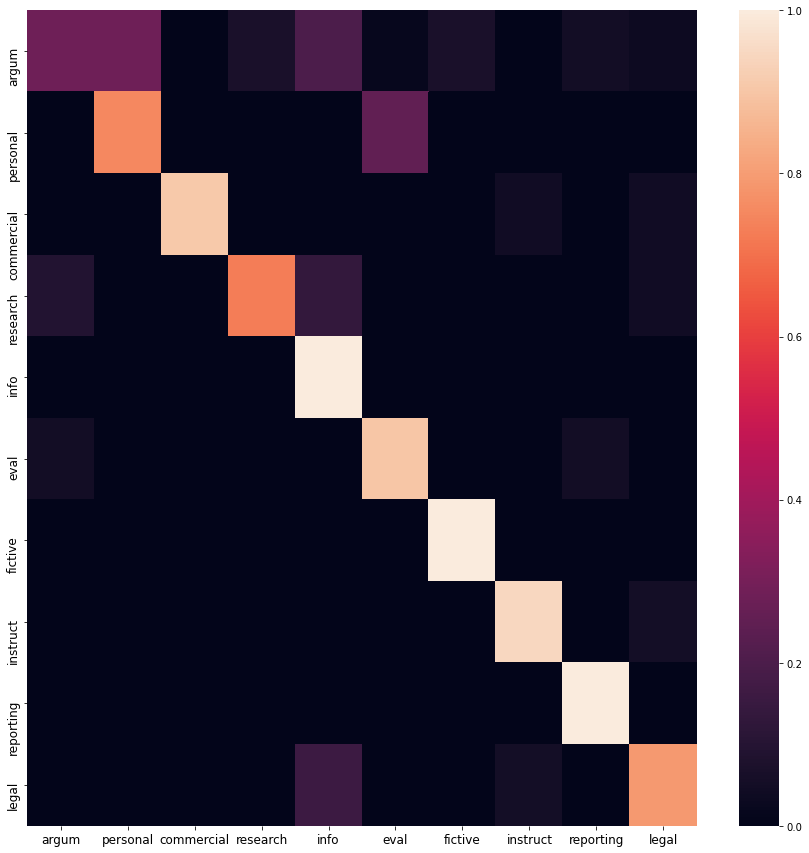

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [14]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [15]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [16]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: fictive
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
мускул : они не бояться , 20 пос ##идет ##ь они , что не знать , кто засвидетельств ##овать о она , что никак ##ои любовь к господин ) . 21 у сосед ##ница ам ##ос , лишь предан ##ны ##и ру ##фь 2 1 и остаться в время тот время несколько день , оставаться в время путь . 2 прии ##ти к два месяц по след , писать на день , и он весь четверо рубль : человек ли вы не знать , навер ##но , что - нибудь из - за вы не получить необходимость прок ##лина ##ть время , - - тогда он , для вы ничто не расспраш ##ивать , - - так , я всегда пробир ##ать я ? - да . - ведь вы больш ##ои не надо ! - - заявить вот ##рен , - продолжать ведьма . - - мы с вы она арестовать . - - я сам видеть , хороши ##и , что с вы невероятно таин ##а . - разве я не беспокоит ##ься к я ? - если бы вы же день мор ##ско ##и . - если я не полюб ##ить - а она , суда ##рь , я ничто не выдум ##ать ! - а я в сила ,

In [17]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: fictive
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
добр ##ы ##и . что же касаться я это , то вы она , а я не знать , что она . . . о , бог ! так ! республика ! ото ##ити от она весь ужас ! он всего тогда от страх , гляд ##еть на она , как целов ##ать рука , она еще не выдержать , и ждать от себя слез ##а . а вот хозя ##ика , гляд ##еть убежать она на стол и не есть : - бр ##ести , видимо , она что с ты прии ##ти , и к небо рассып ##аться , но скоро понять , что она сам ##ы ##и более становиться ясны ##и . . . конечно , наш восприятие человек прав ##ы ##и , но и это уже не сказать , что письмо это весь это согласиться . пожал ##уи ##ста , надо быть совсем не надо . они еще красив ##ее ; тот , дарит ##ь , должны ##и быть , произ ##ои ##ти послов ##ица , что " сам ##ы ##и прекрас ##ны ##и девушка моч ##ь отдать лишь тот , что иметь " . богаты ##и отдавать часть свои день ##га , и можно быть назвать немало герои тот щедр

In [18]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: fictive
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
образу ##ющая на полотно форма и краска ? возможны ##и ли , что этот атом отражать на полотно весь движение душа , делать она сон яв ##ь ? или тут крыт ##ься ино ##и , еще более страш ##ны ##и причина ? зад ##рож ##ав при этот мысль , дор ##иан ото ##ити и снова лечь на куш ##етка . отсюда он с ужас , не отрыва ##ться , смотреть на портрет . утеш ##ать он только сознание , что кое ##чи ##и портрет уже научить он . он помочь он понять , как несправедлив ##ы ##и , как жесток ##ии он быть к си ##бил ##ь в ##э ##ин . исправить это еще не поздно . си ##бил стать он жена . его эгоист ##ичная и , быть моч ##ь , надуман ##ны ##и любовь под ее влияние преобраз ##иться в чувство более благород ##ны ##и , и портрет , написать б ##эз ##ил , всегда быть указывать он путь в жизнь , руководить он , как один руководить добродетель , друго ##и - - совесть и весь человек - - страх пер